# 提案手法の実験（ラベルが適切か出力）

## マルチサイズ
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import csv

import numpy as np
import pandas as pd
import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback
# from tf.keras.utils import multi_gpu_model


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 300
encord_size = int(max_size / 2)

NOTEBOOK_NAME = 'wafermap_multisize_train'
cnn_path = './model/cnn_' + str(max_size) + '_' + 'NOTEBOOK_NAME' + '.h5'

epoch = 30
batch_size = 2048

In [4]:
faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


In [5]:
x_test = joblib.load('./data/multi_' + str(max_size) + '/test/xtest.pickle')
y_test = joblib.load('./data/multi_' + str(max_size) + '/test/ytest.pickle')
y_test = to_categorical(y_test)

In [24]:
for i in range(x_test.shape[0]):
#     plt.imshow(np.argmax(x_test[i], axis=2))
#     print(np.argmax(y_test[i], axis=0))
    print((np.count_nonzero(np.argmax(x_test[i, encord_size, :], axis=1) != 0), np.count_nonzero(np.argmax(x_test[i, :, encord_size], axis=1) != 0)))
#     plt.show()

(27, 25)
(27, 25)
(27, 25)
(27, 25)
(43, 50)
(40, 40)
(42, 41)
(31, 35)
(27, 25)
(27, 25)
(44, 44)
(27, 25)
(40, 35)
(46, 39)
(26, 25)
(40, 40)
(27, 25)
(27, 25)
(27, 25)
(31, 31)
(27, 25)
(27, 25)
(27, 25)
(27, 25)
(36, 35)
(27, 25)
(37, 39)
(27, 25)
(27, 25)
(50, 39)
(43, 50)
(27, 25)
(34, 34)
(27, 25)
(27, 25)
(40, 40)
(25, 27)
(27, 25)
(37, 39)
(27, 25)
(27, 25)
(26, 29)
(27, 25)
(33, 31)
(59, 52)
(61, 62)
(27, 25)
(34, 30)
(26, 26)
(59, 52)
(71, 54)
(42, 41)
(31, 35)
(44, 51)
(42, 41)
(42, 41)
(42, 41)
(37, 39)
(42, 41)
(42, 41)
(31, 35)
(41, 44)
(41, 56)
(31, 35)
(55, 37)
(58, 57)
(42, 41)
(42, 54)
(31, 35)
(50, 45)
(31, 35)
(42, 41)
(42, 41)
(37, 39)
(55, 37)
(71, 54)
(42, 41)
(30, 30)
(42, 41)
(71, 76)
(42, 41)
(42, 41)
(58, 57)
(42, 41)
(42, 41)
(50, 45)
(42, 41)
(25, 27)
(42, 41)
(41, 56)
(40, 35)
(58, 57)
(42, 41)
(44, 42)
(31, 35)
(44, 51)
(42, 41)
(71, 54)
(42, 41)
(59, 53)
(37, 39)
(33, 41)
(37, 39)
(50, 22)
(39, 49)
(39, 49)
(94, 80)
(72, 64)
(31, 39)
(61, 42)
(80, 58)
(

In [25]:
model = models.load_model('./model/cnn_300_NOTEBOOK_NAME.h5')

In [26]:
model.predict(x_test[0].reshape(1, 300, 300, 3))

array([[9.9985921e-01, 4.0826977e-22, 1.7165874e-05, 1.1839517e-04,
        2.3216962e-09, 1.4945446e-30, 2.5877157e-15, 2.2802613e-18,
        5.2422101e-06]], dtype=float32)

### 各ウエハにラベル付け

In [6]:
# trials = 2
# label_list = []
# for i in range(new_x.shape[0]):
#     label_dict = {'wafer_id':str(i).zfill(6), 'true_label':y[i][0], 'predict_label':None, 'augmentation':{'noise':0, 'rotation':0, 'inversion':0}, 'trials':trials}
#     label_list.append(label_dict)

In [7]:
# print(label_list[1])

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

- 保存/読み込み

In [8]:
# MAKE_DATASET = False
# ver = 'shawon' if shawon else 'propose'
# if MAKE_DATASET:
#     pickle_dump(new_x, './data/new_x_' + ver + '.pickle')
#     pickle_dump(new_y, './data/new_y_' + ver + '.pickle')
#     pickle_dump(label_list, './data/label_list_' + ver + '.pickle')
    
# if not MAKE_DATASET:
#     new_x = pickle_load('./data/new_x_' + ver + '.pickle')
#     new_y = pickle_load('./data/new_y_' + ver + '.pickle')
#     label_list = pickle_load('./data/label_list_' + ver + '.pickle')

In [9]:
# for i, l in enumerate(faulty_case):
#     new_y[new_y==l] = i

In [10]:
# for i in range(len(label_list)):
#     label_list[i]['true_label'] = new_y[i][0]

### データの読み出し

In [ ]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/train/' + '*.npy'))
TRAINS = ['./data/multi_' + str(max_size) + '/train/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/train/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

indices = np.array(range(len(TRAINS)))
x_train, x_validation, y_train, y_validation, indices_train, indices_validation = train_test_split(
    TRAINS, new_y, indices, test_size=0.01, random_state=2020)

In [ ]:
# batchを取得する関数
from multiprocessing import Pool
import time

def load_array(file):
    return np.load(file)

def get_batch(batch_size): 
    global x_train, y_train
    SIZE = len(x_train)
    # n_batchs
    n_batchs = SIZE//batch_size + 1
    # for でyield
    i = 0
    start = time.time()
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
        Y_batch = y_train[(i * batch_size):((i + 1) * batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        X_batch_name = x_train[(i * batch_size):((i + 1) * batch_size)]

        # filenameにしたがってバッチのtensorを構築
        with Pool() as p:
            arr = p.map(load_array, X_batch_name)
            
        X_batch = np.array(arr).reshape(len(X_batch_name), max_size, max_size, 3)
#         X_batch = np.array([np.load(file)
#                             for file in X_batch_name]).reshape(len(X_batch_name), max_size, max_size, 3)
        i += 1
        print('elapsed time', time.time()-start)
        yield X_batch, Y_batch

In [13]:
# # testsize = 2000
# # randlist = rand_ints_nodup(0, new_x.shape[0]-1, testsize)

# # valx = new_x.copy()[randlist, :, :, :]
# # valy = y.copy()[randlist, :]

# test_size = 705 #705
# new_x_size = new_x.shape[0]
# testlist = rand_ints_nodup(0, new_x_size-1, test_size)
# trainlist = [i for i in range(new_x_size) if i != testlist]
# new_X=new_x[trainlist]
# new_Y=new_y[trainlist]
# test_x=new_x[testlist]
# test_y=new_y[testlist]

# label_train = copy.deepcopy([label_list[i] for i in trainlist])
# label_test = copy.deepcopy([label_list[i] for i in testlist])

# test_x.shape

In [14]:
# new_X=new_x
# new_Y=new_y

- 学習データとテストデータに分割する．

In [15]:
# indices = np.array(range(new_X.shape[0]))

# x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(new_X, new_Y, indices,
#                                                                 test_size=0.33,
#                                                                 random_state=2020)

In [16]:
# label_vali = copy.deepcopy([label_train[i] for i in indices_test.tolist()])
# label_train = copy.deepcopy([label_train[i] for i in indices_train.tolist()])

In [ ]:
print('Train x : {}, y : {}'.format(len(x_train), y_train.shape))
print('Validation x: {}, y : {}'.format(len(x_validation), y_validation.shape))

In [ ]:
print("loading X_validation...")
with Pool() as p:
    arr = p.map(load_array, x_validation)

x_validation = np.array(arr).reshape(len(x_validation), max_size, max_size, 3)

- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [ ]:
def create_model():
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(8, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(64, activation='relu')(flat)
        dense_2 = layers.Dense(32, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [20]:
# model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# # 3-Fold Crossvalidation
# kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
# # results = cross_val_score(model, x_train, y_train, cv=kfold)
# # # Check 3-fold model's mean accuracy
# # print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [ ]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "device:XLA_GPU:0"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [ ]:
epoch=5
batch_size=256
random.seed(1)

In [ ]:
model = create_model()
epoch_train_loss = []
epoch_train_acc = []
epoch_validation_loss = []
epoch_validation_acc = []
for ep in range(epoch):
    print("=" * 50)
    print(ep, "/", epoch)
    step_loss = []
    step_acc = []
    
    # batch_size=1000でHDDからバッチを取得する
    for X_batch, Y_batch in get_batch(batch_size):
        model.train_on_batch(X_batch, Y_batch)
        score = model.evaluate(X_batch, Y_batch)
        print("batch loss:", score[0])
        print("batch accuracy:", score[1])
        step_loss.append(score[0])
        step_acc.append(score[1])
    print("Train loss", np.mean(step_loss))
    print("Train accuracy", np.mean(step_acc))
    score = model.evaluate(x_validation, y_validation)
    print("Validation loss:", score[0])
    print("Validation accuracy:", score[1])
    epoch_train_loss.append(np.mean(step_loss))
    epoch_train_acc.append(np.mean(step_acc))
    epoch_validation_loss.append(score[0])
    epoch_validation_acc.append(score[1])
    
    shuffle_indices = random.sample(list(range(len(x_train))), len(x_train))
    x_train = [x_train[i] for i in shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    model.save(cnn_path)

In [25]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|       352|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|             MAKE_DATASET|        24|
|                      Out|       248|
|                     Pool|        72|
|                   TRAINS|   2678104|
|       TRAIN_AUTO_ENCODER|        24|
|                  X_batch|       144|
|                  Y_batch|       112|
|                      arr|     24240|
|               batch_size|        28|
|                 cnn_path|        67|
|                     copy|        88|
|             create_model|       144|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                data_size|        28|
|                 datapath|        59|
|                   device|        80|
|                  dirnam

### テストデータで評価

In [26]:
x_test = joblib.load('./data/multi_' + str(max_size) + '/test/xtest.pickle')
y_test = joblib.load('./data/multi_' + str(max_size) + '/test/ytest.pickle')
y_test = to_categorical(y_test)

In [27]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
testscore = score[1]
trainscore = epoch_train_acc[-1]
valiscore = epoch_validation_acc[-1]
print("Train accuracy:", trainscore)
print("Validation accuracy:", valiscore)
print("Test accuracy:", testscore)

15/15 [==============================] - 5s 323ms/step - accuracy: 0.3067 - loss: 13.0061
Test loss: 13.00613784790039
Test accuracy: 0.30666667222976685
Train accuracy: 0.9972967012403764
Validation accuracy: 0.9625951647758484
Test accuracy: 0.30666667222976685


In [28]:
y_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
np.sum(y_test_max == y_predict, axis=0, dtype='float') / x_test.shape[0]

0.30666666666666664

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [29]:
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 300, 300, 8)       224       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 300, 300, 16)      1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 300, 300, 32)      4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880000)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)   

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

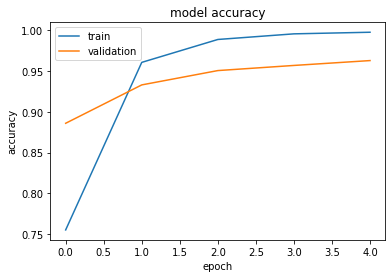

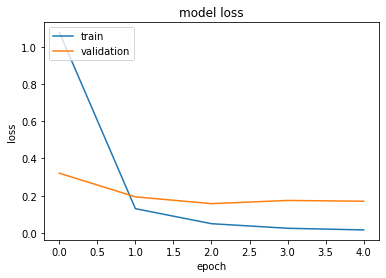

In [30]:
# accuracy plot
fig1 = plt.figure()
plt.plot(epoch_train_acc)
plt.plot(epoch_validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig1.savefig("multisize_accuracy.png")

# loss plot
fig2 = plt.figure()
plt.plot(epoch_train_loss)
plt.plot(epoch_validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig2.savefig("multisize_loss.png")

### 混同行列

In [31]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


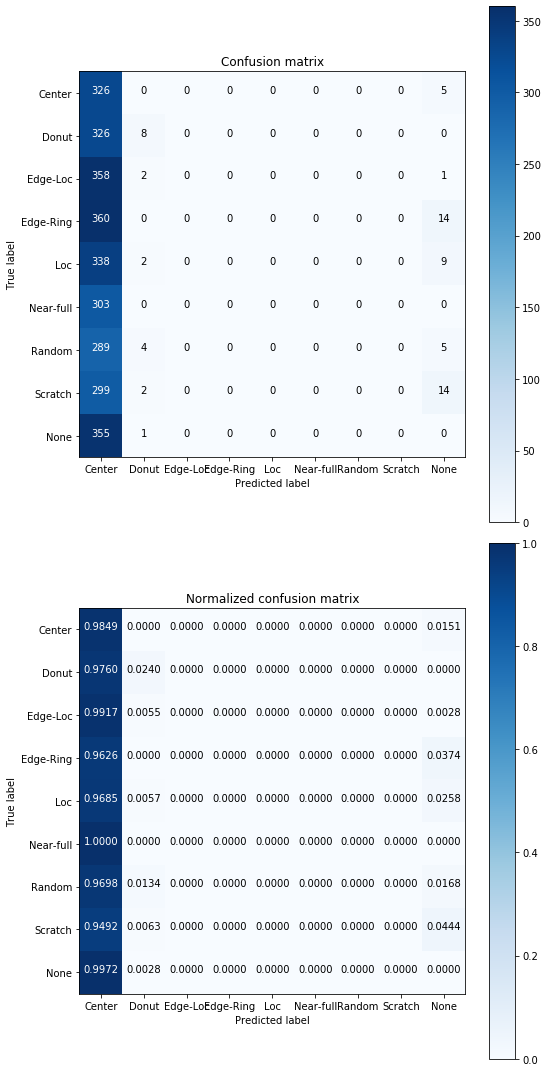

In [32]:
# Compute confusion matrix
y_validation_predict = np.argmax(model.predict(x_validation), axis=1)
y_validation_max = np.argmax(y_validation, axis=1)
cnf_matrix = confusion_matrix(y_validation_max, y_validation_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_valiconfmat.png")

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


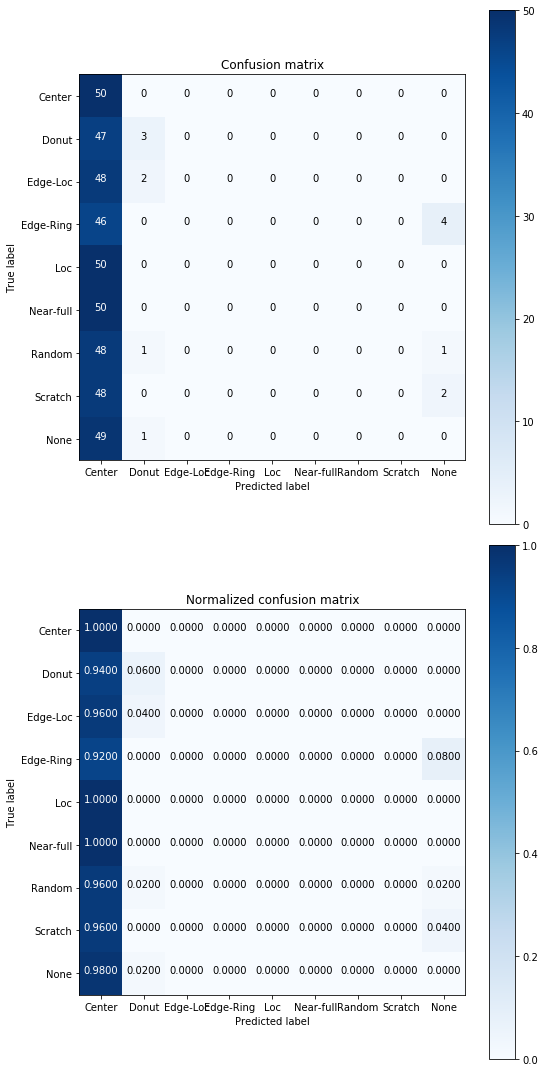

In [33]:
# Compute confusion matrix
y_test_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(y_test_max, y_test_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_testconfmat.png")

In [53]:
import requests

# LINEの設定
path = './lineapi.txt'
with open(path) as f:
    s = f.read()
    line_token = s.rstrip('\n')

# LINEに通知する関数
def line_notify(text):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, headers=headers)#, proxies=proxies)

# LINEに画像を送る関数
def line_notify_img(text, imgpath):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text, "notificationDisabled": True}
    files = {"imageFile": open(imgpath, "rb")}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, files=files, headers=headers)#, proxies=proxies)
    
line_notify("学習が終了しました ")
# line_notify("Shawon: " + str(shawon) + ", rotation_num: " + str(rotation_num) + ", inversion: " + str(inversion) + ", trials: " + str(trials))
line_notify_img("正解率", "multisize_accuracy.png")
line_notify_img("Loss", "multisize_loss.png")
line_notify_img("validation混同行列", "multisize_valiconfmat.png")
line_notify_img("test混同行列", "multisize_testconfmat.png")
line_notify("train:" + str(trainscore) + "\nvali:" + str(valiscore) + "\ntest:" + str(testscore))

KeyboardInterrupt: 